In [151]:
from enum import Enum
import os

TRAIN_DIR = os.path.join('../input', 'rsna-intracranial-hemorrhage-detection', 'stage_1_train_images', '')
TEST_DIR = os.path.join('../input', 'rsna-intracranial-hemorrhage-detection', 'stage_1_test_images', '')
CSV_FILENAME = 'Submission.csv'

class HemorrhageTypes(Enum):
    EP = "epidural"
    IN_PA = "intraparenchymal"
    IN_VE = "intraventricular"
    SUB_AR = "subarachnoid"
    SUB_DU = "subdural"
    ANY = "any"


# There are at least 5 windows that a radiologist goes through for each scan!
# Brain Matter window : W:80 L:40
# Blood/subdural window: W:130-300 L:50-100
# Soft tissue window: W:350–400 L:20–60
# Bone window: W:2800 L:600
# Grey-white differentiation window: W:8 L:32 or W:40 L:40
BRAIN_MATTER_WINDOW = (40, 80)
SUBDURAL_WINDOW = (80, 200)
SOFT_TISSUE_WINDOW = (40, 380)
BONE_WINDOW = (600, 2800)
GRAY_WHITE_DIFFERENTIATION_WINDOW = (40, 40)

ALL_WINDOW_VALUES = {'BRAIN_MATTER': BRAIN_MATTER_WINDOW,
                     'SUBDURAL': SUBDURAL_WINDOW,
                     'SOFT_TISSUE': SOFT_TISSUE_WINDOW,
                     'BONE': BONE_WINDOW,
                     'GRAY_WHITE': GRAY_WHITE_DIFFERENTIATION_WINDOW}

KERNEL_WIDTH = 13
KERNEL_HEIGHT = 13
GAUSS_MEAN = 0.1
GAUSS_STDDEV = 0.05
BRIGHTNESS_DELTA = 0.4

In [152]:
def create_output_csv(output_dict):
    content = "ID,Label\n"
    for image_id in output_dict:
        for num, hemorrhageType in enumerate(HemorrhageTypes, start=0):
            content += create_output_line(image_id, hemorrhageType.value, output_dict[image_id][num])
    with open(CSV_FILENAME, "w") as f:
        f.write(content)


def create_output_line(image_id, hemorrhage_type, probability):
    return "ID_" + image_id + "_" + hemorrhage_type + "," + str(probability) + "\n"


In [153]:
import os
import pandas as pd
import glob
import pydicom
import numpy as np


def get_sequence_clipping_order(seq_length):
    indices = []
    elem = 0
    for idx, i in enumerate(reversed(range(seq_length))):
        indices.append(elem)
        if idx % 2 == 0:
            elem += i
        else:
            elem -= i
    return indices


def print_error(message):
    c_red = '\033[95m'
    c_end = '\033[0m'
    print(c_red + message + c_end)


def get_csv_train(data_prefix=TRAIN_DIR):
    train_df = pd.read_csv(os.path.join(data_prefix, 'stage_1_train.csv'))
    train_df[['ID', 'subtype']] = train_df['ID'].str.rsplit('_', 1,
                                                            expand=True)
    train_df = train_df.rename(columns={'ID': 'id', 'Label': 'label'})
    train_df = pd.pivot_table(train_df, index='id',
                              columns='subtype', values='label')
    train_df.to_csv("labels.csv")
    return train_df


def extract_csv_partition():
    df = get_csv_train()
    meta_data_train = combine_labels_metadata(TRAIN_DIR)
    negative, positive = df.loc[df['any'] == 0], df.loc[df['any'] == 1]
    negative_study_uids = list(meta_data_train.query("any == 0")['StudyInstanceUID'])
    indices = np.arange(min(len(negative_study_uids), len(positive.index)))
    np.random.shuffle(indices)
    negative_study_uids = np.array(negative_study_uids)[indices]
    selected_negative_studies = meta_data_train.loc[meta_data_train['StudyInstanceUID'].isin(negative_study_uids)]
    selected_negative_studies = selected_negative_studies.drop(
        set(selected_negative_studies.columns).intersection(set(negative.columns)), axis=1)
    negative = negative.merge(selected_negative_studies, how='left', on='id').dropna()
    negative = negative.drop(selected_negative_studies.columns, axis=1)
    return pd.concat([positive, negative])


def extract_metadata(data_prefix=TRAIN_DIR):
    filenames = glob.glob(os.path.join(data_prefix, "*.dcm"))
    get_id = lambda p: os.path.splitext(os.path.basename(p))[0]
    ids = map(get_id, filenames)
    dcms = map(pydicom.dcmread, filenames)
    columns = ['BitsAllocated', 'BitsStored', 'Columns', 'HighBit',
               'Modality', 'PatientID', 'PhotometricInterpretation',
               'PixelRepresentation', 'RescaleIntercept', 'RescaleSlope',
               'Rows', 'SOPInstanceUID', 'SamplesPerPixel', 'SeriesInstanceUID',
               'StudyID', 'StudyInstanceUID', 'ImagePositionPatient',
               'ImageOrientationPatient', 'PixelSpacing']
    meta_dict = {col: [] for col in columns}
    for img in dcms:
        for col in columns:
            meta_dict[col].append(getattr(img, col))
    meta_df = pd.DataFrame(meta_dict)
    del meta_dict
    meta_df['id'] = pd.Series(ids, index=meta_df.index)
    split_cols = ['ImagePositionPatient1', 'ImagePositionPatient2',
                  'ImagePositionPatient3', 'ImageOrientationPatient1',
                  'ImageOrientationPatient2', 'ImageOrientationPatient3',
                  'ImageOrientationPatient4', 'ImageOrientationPatient5',
                  'ImageOrientationPatient6', 'PixelSpacing1',
                  'PixelSpacing2']
    meta_df[split_cols[:3]] = pd.DataFrame(meta_df.ImagePositionPatient.values.tolist())
    meta_df[split_cols[3:9]] = pd.DataFrame(meta_df.ImageOrientationPatient.values.tolist())
    meta_df[split_cols[9:]] = pd.DataFrame(meta_df.PixelSpacing.values.tolist())
    meta_df = meta_df.drop(['ImagePositionPatient', 'ImageOrientationPatient', 'PixelSpacing'], axis=1)
    return meta_df


def combine_labels_metadata(data_prefix=TRAIN_DIR):
    meta_df = extract_metadata(data_prefix)
    df = get_csv_train(data_prefix)
    df = df.merge(meta_df, how='left', on='id').dropna()
    df.sort_values(by='ImagePositionPatient3', inplace=True, ascending=False)
    df.to_csv(os.path.join(data_prefix, 'train_meta.csv'))
    return df


In [154]:
import cv2


# the kernel sizes must be positive odd integers but they do not have to be equal
# the larger they are the more the image will be blurred


def blur_image(pixel_matrix, kernel_size_width=KERNEL_WIDTH, kernel_size_height=KERNEL_HEIGHT):
    return cv2.GaussianBlur(pixel_matrix, (kernel_size_width, kernel_size_height), cv2.BORDER_DEFAULT)


def noisy(image, mean=GAUSS_MEAN, stddev=GAUSS_STDDEV):
    gauss = np.random.normal(mean, stddev, image.shape)
    noisy = image + gauss
    noisy_min = np.amin(noisy)
    noisy_max = np.amax(noisy)
    noisy = (noisy - noisy_min) / (noisy_max - noisy_min)
    return noisy


def adjust_brightness(image, delta=BRIGHTNESS_DELTA):
    image += delta
    image[image < 0] = 0
    image[image > 1] = 1
    return image

In [155]:
import copy

import pydicom
import scipy
from skimage import morphology
from skimage.transform import resize


class Preprocessor:

    @staticmethod
    def apply_hounsfield(image, intercept, slope):
        if slope is not 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.float64)

        image += np.float64(intercept)

        # Setting values smaller than air, to air. Values smaller than -1024, are probably just outside the scanner.
        image[image < -1024] = -1024
        return image

    @staticmethod
    def windowing(image, custom_center=30, custom_width=100, rescale=True):
        new_image = copy.deepcopy(image)
        min_value = custom_center - (custom_width / 2)
        max_value = custom_center + (custom_width / 2)

        # Including another value for values way outside the range, to (hopefully) make segmentation processes easier.
        new_image[new_image < min_value] = min_value
        new_image[new_image > max_value] = max_value
        if rescale:
            new_image = (new_image - min_value) / (max_value - min_value)
        return new_image

    @staticmethod
    def image_resample(image, pixel_spacing, new_spacing=[1, 1]):
        pixel_spacing = map(float, pixel_spacing)
        spacing = np.array(list(pixel_spacing))
        resize_factor = spacing / new_spacing
        new_real_shape = image.shape * resize_factor
        new_shape = np.round(new_real_shape)
        real_resize_factor = new_shape / image.shape

        image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
        return image

    @staticmethod
    def image_background_segmentation(image, WL=30, WW=100, rescale=True):
        lB = WW - WL
        uB = WW + WL

        # Keep only values inside of the window
        background_separation = np.logical_and(image > lB, image < uB)

        # Get largest connected component:
        # From https://github.com/nilearn/nilearn/blob/master/nilearn/_utils/ndimage.py
        background_separation = morphology.dilation(background_separation, np.ones((5, 5)))
        labels, label_nb = scipy.ndimage.label(background_separation)

        label_count = np.bincount(labels.ravel().astype(np.int))
        # discard the 0 label
        label_count[0] = 0
        mask = labels == label_count.argmax()

        # Fill holes in the mask
        mask = morphology.dilation(mask, np.ones((5, 5)))  # dilate the mask for less fuzy edges
        mask = scipy.ndimage.morphology.binary_fill_holes(mask)
        mask = morphology.dilation(mask, np.ones((3, 3)))  # dilate the mask again

        image = mask * image

        if rescale:
            img_min = np.amin(image)
            img_max = np.amax(image)
            image = (image - img_min) / (img_max - img_min)
        return image

    @staticmethod
    def preprocess(image_path):
        dicom = pydicom.read_file(image_path)
        image = dicom.pixel_array.astype(np.float64)
        if image.shape != (512, 512):
            image = resize(image, (512, 512))
        p = Preprocessor
        image = p.apply_hounsfield(image, dicom.RescaleIntercept, dicom.RescaleSlope)
        image = p.windowing(image)
        return image

    @staticmethod
    def augment(image):
        augmented = list()
        augmented.append(blur_image(image))
        augmented.append(noisy(image))
        augmented.append(adjust_brightness(image, 0.3))
        return augmented

In [156]:
import os
import random

from keras.utils import Sequence


class DataGenerator(Sequence):

    def __init__(self, list_ids, labels=None, batch_size=1, img_size=(512, 512, 3),
                 img_dir=TRAIN_DIR, shuffle=True, n_classes=2):
        self.list_ids = list_ids
        self.indices = np.arange(len(self.list_ids))
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.shuffle = shuffle
        self.n_classes = n_classes
        # TODO: this could be generalized with the help of
        # an Augmenter class
        self.n_augment = 3  # 3 data augmentation functions
        self.augment_funcs = [blur_image,
                              noisy,
                              adjust_brightness,
                              lambda img: img]  # identity function
        self.on_epoch_end()
        if labels is not None:
            # Weights should be a probability distribution.
            # If the number of training instances is too large,
            # there could be issues! (arithmetic underflow)
            weight_func = lambda row: 1.0 if row["any"] == 0 else self.n_augment + 1
            self.weights = labels.apply(weight_func, axis=1)
            total = self.weights.sum()
            self.weights = (self.weights / total).values
        # set random seed, hope this randomizes starting value for
        # each worker
        random.seed(os.urandom(8))

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indices = np.random.choice(self.indices, size=self.batch_size,
                                   replace=False, p=self.weights)
        return self.__data_generation(indices)

    # Don't think this is necessary anymore, indices are sampled randomly.
    def on_epoch_end(self):
        pass

    def __data_generation(self, indices):
        x = np.empty((self.batch_size, *self.img_size))
        if self.labels is not None:  # training phase
            if self.n_classes == 2:
                y = np.empty((self.batch_size,), dtype=np.float32)
            else:
                y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
            for i, idx in enumerate(indices):
                image = Preprocessor.preprocess(self.img_dir + self.list_ids[idx] + ".dcm")
                if self.labels.iloc[idx]['any'] == 1:
                    image = self.augment_funcs[random.randint(0, self.n_augment)](image)
                image = np.array(image)
                image = np.repeat(image[..., np.newaxis], 3, -1)
                x[i, ] = image
                if self.n_classes == 2:
                    y[i, ] = self.labels.iloc[idx]['any']
                else:
                    y[i, ] = self.labels.iloc[idx, 1:]
            return x, y
        else:  # test phase
            for i, idx in enumerate(indices):
                image = Preprocessor.preprocess(self.img_dir + self.list_ids[idx] + ".dcm")
                image = np.repeat(image[..., np.newaxis], 3, -1)
                x[i, ] = image
            return x

In [157]:
import os
from keras.utils import Sequence


class LSTMDataGenerator(Sequence):

    def __init__(self, list_ids, labels=None, batch_size=1, img_size=(512, 512, 3),
                 sequence_size=40, img_dir='data/train', shuffle=True):
        # here, list_ids is a series of lists; each list represents an
        # ordered sequence of scans that compose a single study
        self.list_ids = list_ids
        self.indices = np.arange(len(self.list_ids))
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_size = sequence_size
        self.img_dir = img_dir
        self.shuffle = shuffle
        # TODO: this could be generalized with the help of
        # an Augmenter class
        self.n_augment = 3  # 3 data augmentation functions
        self.augment_funcs = [blur_image,
                              noisy,
                              adjust_brightness,
                              lambda img: img]  # identity function
        self.on_epoch_end()
        if labels is not None:
            # Weights should be a probability distribution.
            # If the number of training instances is too large,
            # there could be issues! (arithmetic underflow)
            weight_func = lambda seq: (float(self.n_augment + 1)
                                       if any([labels[0] for labels in seq])
                                       else 1.0)
            self.weights = np.array(list(map(weight_func, self.labels)))
            total = np.sum(self.weights)
            self.weights = (self.weights / total)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indices = np.random.choice(self.indices, size=self.batch_size,
                                   replace=False, p=self.weights)
        return self.__data_generation(indices)

    def on_epoch_end(self):
        pass

    def __data_generation(self, indices):
        x = np.empty((self.batch_size, self.sequence_size, *self.img_size))
        preprocess_func = lambda im: Preprocessor.preprocess(os.path.join(self.img_dir, im + ".dcm"))
        if self.labels is not None:  # training phase
            y = np.empty((self.batch_size, self.sequence_size, 5), dtype=np.float32)
            for i, idx in enumerate(indices):
                seq = self.list_ids[idx]
                seq_labels = np.array(self.labels[idx])
                seq_len = len(seq)
                # if there is an any label = 1, set has_hemorrhage flag
                has_hemorrhage = np.any(seq_labels[0])
                imgs = map(preprocess_func, seq)
                if has_hemorrhage:
                    # augment images
                    func_idxs = np.random.randint(0, self.n_augment + 1,
                                                  size=seq_len)
                    imgs = [self.augment_funcs[j](img)
                            for j, img in zip(func_idxs, imgs)]
                else:
                    # consume map generator
                    imgs = list(imgs)
                imgs = np.array(imgs)
                imgs = np.repeat(imgs[..., np.newaxis], 3, -1)
                diff = seq_len - self.sequence_size
                if diff < 0:
                    padding = np.repeat(np.zeros(imgs.shape[1:])[np.newaxis, ...], abs(diff), 0)
                    imgs = np.concatenate((imgs, padding), axis=0)
                    seq_labels = np.concatenate(seq_labels, np.zeros(6), axis=0)
                elif diff > 0:
                    indices = get_sequence_clipping_order(seq_len)
                    imgs = np.delete(imgs, indices[:diff], 0)
                    seq_labels = np.delete(seq_labels, indices[:diff], 0)
                x[i, ] = imgs
                y[i, ] = seq_labels[:, 1:]
            return x, y
        else:  # test phase
            for i, idx in enumerate(indices):
                seq = self.list_ids[idx]
                seq_len = len(seq)
                imgs = np.array(list(map(preprocess_func, seq)))
                imgs = np.repeat(imgs[..., np.newaxis], 3, -1)
                diff = seq_len - self.sequence_size
                if diff < 0:
                    padding = np.repeat(np.zeros(imgs.shape[1:])[np.newaxis, ...], abs(diff), 0)
                    imgs = np.concatenate((imgs, padding), axis=0)
                elif diff > 0:
                    indices = get_sequence_clipping_order(seq_len)
                    imgs = np.delete(imgs, indices[:diff], 0)
                x[i, ] = imgs
            return x

In [158]:
from keras.applications import NASNetLarge, InceptionResNetV2, Xception, DenseNet201, ResNet50
from keras.layers import Bidirectional, LSTM, TimeDistributed, Masking
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input, GlobalAveragePooling2D
from keras.models import Sequential, Model


class StandardModel:

    def __init__(self, network, input_shape, pooling_method='max', classes=2, use_softmax=True):
        self.base_model = self.get_base_model(network, input_shape, pooling_method)
        self.classes = classes
        self.use_softmax = use_softmax
        self.input_shape = input_shape

    @staticmethod
    def get_base_model(network, input_shape, pooling_method):
        network = network.lower()
        input_warning_message = 'WARNING! The input shape is not the default one!!! Proceeding anyway!'
        if network == 'nas':
            if input_shape != (331, 331, 3):
                print_error(input_warning_message)
            return NASNetLarge(input_shape=input_shape, include_top=False, pooling=pooling_method,
                               weights=None)
        elif network == 'inception':
            if input_shape != (299, 299, 3):
                print_error(input_warning_message)
            return InceptionResNetV2(input_shape=input_shape, include_top=False, pooling=pooling_method,
                                     weights='imagenet')
        elif network == 'xception':
            if input_shape != (299, 299, 3):
                print_error(input_warning_message)
            return Xception(input_shape=input_shape, include_top=False, pooling=pooling_method,
                            weights='imagenet')
        elif network == 'densenet':
            if input_shape != (224, 224, 3):
                print_error(input_warning_message)
            return DenseNet201(input_shape=input_shape, include_top=False, pooling=pooling_method,
                               weights='imagenet')
        elif network == 'resnet':
            if input_shape != (224, 224, 3):
                print_error(input_warning_message)
            return ResNet50(input_shape=input_shape, include_top=False, pooling=pooling_method,
                            weights='imagenet')
        else:
            print_error(f'Invalid network name: {network}! Please choose from: \n ')
            return None

    def build_model(self):
        return self.build_binary_model() if self.classes == 2 else self.build_multi_class_model()

    def build_binary_model(self):
        model = Sequential()
        model.add(self.base_model)
        model.add(Dense(96))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
        return model

    def build_multi_class_model(self):
        return self.build_probability_model() if self.use_softmax else self.build_recurrent_model()

    def build_probability_model(self):
        model = Sequential()
        model.add(self.base_model)
        model.add(Dense(96))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.3))
        model.add(Dense(5, activation='softmax'))
        return model

    def build_recurrent_model(self):
        inputs = Input(shape=(40, *self.input_shape))
        time_dist = TimeDistributed(self.base_model)(inputs)
        global_pool = TimeDistributed(GlobalAveragePooling2D())(time_dist)
        dense_relu = TimeDistributed(Dense(256, activation='relu'))(global_pool)

        masked = Masking(0.0)(dense_relu)
        out = Bidirectional(LSTM(256, return_sequences=True, activation='softsign',
                                 dropout=0.2, recurrent_dropout=0.2))(masked)
        out = TimeDistributed(Dense(5, activation='softmax'))(out)

        model = Model(inputs=inputs, outputs=out)
        return model

WARNING! The input shape is not the default one!!! Proceeding anyway!
Epoch 1/1
2246/2246 [==============================] - 1435s 639ms/step - loss: 0.2848 - acc: 0.8846
0.09722843766212463 0.9037972092628479
Epoch 1/1
 408/2246 [====>.........................] - ETA: 19:32 - loss: 0.2479 - acc: 0.9044

KeyboardInterrupt: 

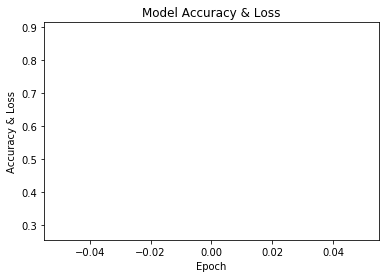

In [159]:
import glob
import os
import sys
import time

import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adamax
from sklearn.metrics import log_loss
from keras.callbacks import ModelCheckpoint, Callback

class WeightsSaver(Callback):
    def __init__(self, N):
        self.N = N
        self.batch = 0

    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            name = 'model_weights.h5'
            self.model.save_weights(name)
        self.batch += 1
        
def prepare_data():
    csv = pd.read_csv(os.path.join('../input/data-misc', 'labels.csv'))
    files = glob.glob(os.path.join(TRAIN_DIR, "*.dcm"))
    files = list(map(lambda x: os.path.splitext(os.path.basename(x))[0], files))
    filtered_csv = csv[csv.id.isin(files)]
    indices = np.random.rand(len(filtered_csv))
    mask = indices < 0.8
    x_train, y_train = list(filtered_csv[mask].id), filtered_csv.iloc[mask, 1:]
    x_test, y_test = list(filtered_csv[~mask].id), filtered_csv.iloc[~mask, 1:]
    #x_train.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    #x_test.reset_index(inplace=True, drop=True)
    y_test.reset_index(inplace=True, drop=True)
    return x_train, y_train, x_test, y_test


def prepare_sequential_data():
    # open label + metadata CSV
    csv = pd.read_csv(os.path.join('../input/data-combined', "train_meta.csv"))
    # sort by study ID and position
    csv.sort_values(by=["StudyInstanceUID", "ImagePositionPatient3"], inplace=True, ascending=False)
    label_columns = ["any", "epidural", "intraparenchymal",
                     "intraventricular", "subarachnoid", "subdural"]
    # filter unnecessary columns
    csv = csv[["StudyInstanceUID", "id"] + label_columns]
    # get sequences of IDs (groupby preserves order)
    sequences = csv.groupby("StudyInstanceUID")["id"].apply(list)
    # group labels into one single column
    csv["labels"] = csv[label_columns].values.tolist()
    # get sequences of labels
    labels = csv.groupby("StudyInstanceUID")["labels"].apply(list)
    indices = np.random.rand(sequences.size)
    # partition data
    mask = indices < 0.8
    x_train, x_test = list(sequences.iloc[mask]), list(sequences.iloc[~mask])
    y_train, y_test = list(labels.iloc[mask]), list(labels.iloc[~mask])
    return x_train, y_train, x_test, y_test


def test_recurrent_network():
    def generate_single_instance(instance):
        images, labels = list(), list()
        for file in instance:
            file_path = os.path.join(TRAIN_DIR, file)
            images.append(Preprocessor.preprocess(file_path))
            labels.append(np.random.uniform(0, 1, 5))
        images = np.stack(images, axis=0)
        labels = np.stack(labels, axis=0)
        return images, labels

    model = StandardModel('xception', (512, 512, 3), classes=5, use_softmax=False, pooling_method=None)
    model = model.build_model()
    model.compile(Adamax(), loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    keras.utils.plot_model(model, show_shapes=True)
    x_train = []
    y_train = []
    data = [['ID_00025ef4b.dcm', 'ID_00027c277.dcm', 'ID_00027cbb1.dcm'],
            ['ID_000229f2a.dcm', 'ID_000230ed7.dcm', 'ID_000270f8b.dcm'],
            ['ID_00025ef4b.dcm', 'ID_00027c277.dcm', 'ID_00027cbb1.dcm']]
    for i in range(3):
        instance_images, instance_labels = generate_single_instance(data[i])
        x_train.append(instance_images)
        y_train.append(instance_labels)
    x_train = np.stack(x_train)
    x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
    y_train = np.stack(y_train)
    print(x_train.shape, y_train.shape)
    model.fit(x_train, y_train, batch_size=1)


def plot_model_graph(history, graph_name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['loss'])
    plt.title('Model Accuracy & Loss')
    plt.ylabel('Accuracy & Loss')
    plt.xlabel('Epoch')
    plt.savefig(graph_name)


def train_binary_model(base_model, already_trained_model=None):
    x_train, y_train, x_test, y_test = prepare_data()
    if not already_trained_model:
        nr_sequences = 30
        sequence_length = len(x_train) // nr_sequences
        model = StandardModel(base_model, (512, 512, 3), classes=2, use_softmax=True)
        model = model.build_model()
        model.compile(Adamax(), loss='binary_crossentropy', metrics=['acc'])
        checkpoint = ModelCheckpoint('binary_model.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')
        start_time = time.time()
        estimated_window = None
        for index in range(nr_sequences):
            frame = (index * sequence_length, (index+1)*sequence_length)
            labels = y_train[frame[0]:frame[1]].reset_index(drop=True)
            history = model.fit_generator(DataGenerator(x_train[frame[0]:frame[1]], labels=labels,
                                                        n_classes=2, batch_size=8), epochs=1)
            plot_model_graph(history, "my_binary_graph.png")
            model.save('binary_model.h5')
            loss, accuracy = model.evaluate_generator(DataGenerator(x_test, labels=y_test, n_classes=2))
            print(loss, accuracy)
            if index == 0:
                estimated_window = time.time() - start_time     # cat a durat un fit
            if (time.time() + estimated_window) - start_time >= 28800:   # daca timpul estimat este mai mare de 8 ore, ii spunem adio
                break
    else:
        if os.path.exists(already_trained_model):
            model = keras.models.load_model(already_trained_model)
            loss, accuracy = model.evaluate_generator(DataGenerator(x_test, labels=y_test, n_classes=2))
            print(loss, accuracy)
        else:
            print_error("Provided model file doesn't exist! Exiting...")
            sys.exit(1)


def train_multi_class_model(base_model, already_trained_model=None):
    x_train, y_train, x_test, y_test = prepare_data()
    if not already_trained_model:
        nr_sequences = 30
        sequence_length = len(x_train) // nr_sequences
        model = StandardModel(base_model, (512, 512, 3), classes=5, use_softmax=True)
        model = model.build_model()
        model.compile(Adamax(), loss='categorical_crossentropy', metrics=['acc'])
        checkpoint = ModelCheckpoint('categorical_model.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')
        start_time = time.time()
        estimated_window = None
        for index in range(nr_sequences):
            frame = (index * sequence_length, (index+1)*sequence_length)
            history = model.fit_generator(DataGenerator(x_train[frame[0]:frame[1]], labels=y_train[frame[0]:frame[1]], 
                                                        n_classes=5, batch_size=8), epochs=1)
            plot_model_graph(history, "my_categorical_graph.png")
            model.save('categorical_model.h5')
            y_pred = model.predict_generator(DataGenerator(x_test, n_classes=5))
            y_test = y_test.iloc[:, 1:]
            print(log_loss(y_test, y_pred))
            if index == 0:
                estimated_window = time.time() - start_time              # cat a durat un fit
            if (time.time() + estimated_window) - start_time >= 28800:   # daca timpul estimat este mai mare de 8 ore, ii spunem adio
                break
    else:
        if os.path.exists(already_trained_model):
            model = keras.models.load_model(already_trained_model)
            y_pred = model.predict_generator(DataGenerator(x_test, n_classes=5))
            y_test = y_test.iloc[:, 1:]
            print(log_loss(y_test, y_pred))
        else:
            print_error("Provided model file doesn't exist! Exiting...")
            sys.exit(1)


def train_recurrent_multi_class_model(base_model, already_trained_model=None):
    x_train, y_train, x_test, y_test = prepare_sequential_data()
    if not already_trained_model:
        model = StandardModel(base_model, (512, 512, 3), classes=5, use_softmax=False, pooling_method=None)
        model = model.build_model()
        model.compile(Adamax(), loss='categorical_crossentropy', metrics=['acc'])
        model.fit_generator(LSTMDataGenerator(x_train, labels=y_train))
        model.save('model.h5')
        y_pred = model.predict_generator(LSTMDataGenerator(x_test))
        print(log_loss(y_test, y_pred))
    else:
        if os.path.exists(already_trained_model):
            model = keras.models.load_model(already_trained_model)
            y_pred = model.predict_generator(LSTMDataGenerator(x_test))
            print(log_loss(y_test, y_pred))
        else:
            print_error("Provided model file doesn't exist! Exiting...")
            sys.exit(1)


def main():
    # TODO: Possible MODELS for training: inception, xception, resnet, densenet, nas
    # train_binary_model('xception')
    # train_multi_class_model('xception')
    # prepare_sequential_data()
    train_binary_model('xception')
    #test_recurrent_network()

main()
